Goal of this notebook is to clean up and structure the code from the initial great work: https://github.com/pinellolab/DNA-Diffusion/blob/dna-diffusion/notebooks/experiments/conditional_diffusion/easy_training_Conditional_Code_to_refactor_UNET_ANNOTATED_v4%20(2).ipynb

This notebook is divided in following chapters:
1. [Utility functions](#utility_functions)
2. [Data import and preperation](#Data-import-and-preperation)
3. [Stable Diffusion architecture](##Stable-Diffusion-architecture)
4. [Stable Diffusion training metric functions and evaluation](##Stable-+-Diffusion-+-training-+-metric-+-functions-+-and-+-evaluation)

Concrete improvements from the previous notebook:

1. Complete restructuring and refactoring of the code.
2. Delete unecessary code
4. Seed set for complete reproducibility (such that we know when improvements are really improving and not due to randomness)
5. Decoupled the logic between data loading and processing
6. Wrote doc strings for most of the classes and functions
7. Exposed hyperparameters immediately at the beggining (for easier hydra refactoring)
8. Added more functionality (such as injectable/interchangable metric functions etc.)
9. Documented all of the main chapters and subchapters, with brief theoretical description behind stable diffusion, architecture tackled there, classifier-Free Diffusion Guidance and EMEA.
10.


**NOTE**: 

1. KL and other metrics remained the same or improved.
2. When calculating KL we are measuring occurances of particular motifs. That means we are not measuring distribution between "letters". This was the assumption from the original nb. We are also not measuring occurances at particular place, just wether and how much a motif occures between the train and test.


The main goal of this notebook is:

1. Set a major pre refactoring step such that we can easily move this to code base.
2. Set an easier entry point to newcomers.
3. Server as the new benchmark for prototyping.
4. As the refactoring is ongoing all of the code here should be abstracted away from imports from the codebase.



# Optional libraries that need to be installed:

In [1]:
!pip install einops
!pip install einops
!pip install torchmetrics
!pip install gimmemotifs    #can take around 10 minutes
!genomepy install hg38
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 231 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 12.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.5 MB 25 kB/s 
     |████████████████████████████████| 12.5 MB 55.1 MB/s 
     |████████████████████████████████| 15.4 MB 49.0 MB/s 
     |████████████████████████████████| 44 kB 3.4 MB/s 
     |████████████████████████████████| 212 kB 57.5 MB/s 
     |████████████████████████████████| 80 kB 9.8 MB/s 
     |████████████████████████████████| 11.8 MB 33.1 MB/s 
     |████████████████████████████████| 58 kB 6.9 MB/s 
     |████████████████████████

# Importing the dependencies:

In [2]:
import os

os.getpid()
from functools import partial
from scipy.stats import zscore
import torch
import copy
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
from IPython.display import display
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from tqdm import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn.modules.activation import ReLU
from torch.optim import Adam
from tqdm import tqdm_notebook
from torchvision.utils import save_image
import matplotlib
import math
from inspect import isfunction
from functools import partial
import scipy
from scipy.special import rel_entr
from torch import nn, einsum
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange
from torch import nn, einsum
import torch.nn.functional as F
import matplotlib.animation as animation
import matplotlib.image as mpimg
import glob
from PIL import Image
from typing import List, Union
from torchmetrics.functional import kl_divergence
import random
import gc
from livelossplot import PlotLosses

%matplotlib inline

### **Hyperparameters** that are exposed and need to be abstracted through hydra like interface and/or (potentially) hyperoptimised:

In [22]:
# Global seed
GLOBAL_SEED = 42
# Nucleic acids encoding the motifs
NUCLEOTIDES = ['A', 'C', 'T', 'G']
# Number of samples to run the training, evaluation. Increase to get statistical significance
N_SAMPLES = 1000
# Enumarate cell names
ENUMARATED_CELL_NAME = '''7 Trophoblasts
5 CD8_cells
15 CD34_cells
9 Fetal_heart
12 Fetal_muscle
14 HMVEC(vascular)
3 hESC(Embryionic)
8 Fetal(Neural)
13 Intestine
2 Skin(stromalA)
4 Fibroblast(stromalB)
6 Renal(Cancer)
16 Esophageal(Cancer)
11 Fetal_Lung
10 Fetal_kidney
1 Tissue_Invariant'''.split(
    '\n'
)
# Cell names
CELL_NAMES = {
    int(x.split(' ')[0]): x.split(' ')[1] for x in ENUMARATED_CELL_NAME
}
# Number of epochs to train for
EPOCHS = 10000
# save and compare metrics after specified epoch
SAVE_AND_SAMPLE_EVERY = 5
# show loss after speficied epoch
EPOCHS_LOSS_SHOW = 5
# Number of BP for the motif
IMAGE_SIZE = 200
# iamge channels, with us singular
CHANNELS = 1
# Learning rate
LEARNING_RATE = 1e-4
# timesteps for diffusion
TIMESTEPS = 50
# Number of resnet block groups in the UNET architecture
RESNET_BLOCK_GROUPS = 4
# Batch size
BATCH_SIZE = 16
# total number of components
TOTAL_CLASS_NUMBER = 17

In [4]:
def seed_everything(seed=GLOBAL_SEED):
    """ "
    Seed everything.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
seed_everything()

Download the data if you dont have it locally:

In [6]:
# #downloading data
!wget https://www.dropbox.com/s/db6up7c0d4jwdp4/train_all_classifier_WM20220916.csv.gz?dl=2
# #changing name
!mv   train_all_classifier_WM20220916.csv.gz?dl=2 train_all_classifier_WM20220916.csv.gz
# #unpcaking
!gunzip -d /train_all_classifier_WM20220916.csv.gz?dl=2 train_all_classifier_WM20220916.csv
# #new seqs

--2022-11-26 10:17:29--  https://www.dropbox.com/s/db6up7c0d4jwdp4/train_all_classifier_WM20220916.csv.gz?dl=2
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/db6up7c0d4jwdp4/train_all_classifier_WM20220916.csv.gz [following]
--2022-11-26 10:17:29--  https://www.dropbox.com/s/raw/db6up7c0d4jwdp4/train_all_classifier_WM20220916.csv.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbcd8e5eef3ef7a6d16db144774.dl.dropboxusercontent.com/cd/0/inline/Bxcfr5LH8pAc4jc9C3ZxSC-wUzvYDj8duIAQTBKgIcRxE8bOKHvepDKfj2a1jLaKZvyg1SLT0_jrx5EzwUygETkXPwOMy00T54qmjJRdiKWxytgK_vA83wnkqH1a66kTREkD3lE-ZjlRdoH3CyTrNx6Pk23LPTa7PFH5lX4jJVswiQ/file# [following]
--2022-11-26 10:17:30--  https://ucbcd8e5eef3ef7a6d16db144774.dl.dropboxusercontent.com/cd/0/i

Mount the drive if you are using data from it:

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

#Utility functions

In [8]:
def motif_scoring_KL_divergence(
    original: pd.Series, generated: pd.Series
) -> torch.Tensor:
    """
    This function encapsulates the logic of evaluating the KL divergence metric
    between two sequences.
    Returns
    -------
    kl_divergence: Float
      The KL divergence between the input and output (generated)
      sequences' distribution
    """

    kl_pq = rel_entr(original, generated)
    return np.sum(kl_pq)

In [9]:
def compare_motif_list(
    df_motifs_a,
    df_motifs_b,
    motif_scoring_metric=motif_scoring_KL_divergence,
    plot_motif_probs=False,
):
    """
    This function encapsulates the logic of evaluating the difference between the distribution
    of frequencies between generated (diffusion/df_motifs_a) and the input (training/df_motifs_b) for an arbitrary metric ("motif_scoring_metric")

    Please note that some metrics, like KL_divergence, are not metrics in official sense. Reason
    for that is that they dont satisfy certain properties, such as in KL case, the simmetry property.
    Hence it makes a big difference what are the positions of input.
    """
    set_all_mot = set(
        df_motifs_a.index.values.tolist() + df_motifs_b.index.values.tolist()
    )
    create_new_matrix = []
    for x in set_all_mot:
        list_in = []
        list_in.append(x)  # adding the name
        if x in df_motifs_a.index:
            list_in.append(df_motifs_a.loc[x][0])
        else:
            list_in.append(1)

        if x in df_motifs_b.index:
            list_in.append(df_motifs_b.loc[x][0])
        else:
            list_in.append(1)

        create_new_matrix.append(list_in)

    df_motifs = pd.DataFrame(
        create_new_matrix, columns=['motif', 'motif_a', 'motif_b']
    )

    df_motifs['Diffusion_seqs'] = (
        df_motifs['motif_a'] / df_motifs['motif_a'].sum()
    )
    df_motifs['Training_seqs'] = (
        df_motifs['motif_b'] / df_motifs['motif_b'].sum()
    )
    if plot_motif_probs:
        plt.rcParams["figure.figsize"] = (3, 3)
        sns.regplot(x='Diffusion_seqs', y='Training_seqs', data=df_motifs)
        plt.xlabel('Diffusion Seqs')
        plt.ylabel('Training Seqs')
        plt.title('Motifs Probs')
        plt.show()

    return motif_scoring_metric(
        df_motifs['Diffusion_seqs'].values, df_motifs['Training_seqs'].values
    )

In [10]:
def metric_comparison_between_components(
    original_data, generated_data, x_label_plot, y_label_plot
):
    """
    This functions takes as inputs dictionaries, which contain as keys different components (cell types)
    and as values the distribution of occurances of different motifs. These two dictionaries represent two different datasets, i.e.
    generated dataset and the input (train) dataset.

    The goal is to then plot a the main evaluation metric (KL or otherwise) across all different types of cell types
    in a heatmap fashion.
    """
    final_comparison_all_components = []
    for components_1, motif_occurance_frequency in original_data.items():
        comparisons_single_component = []
        for components_2 in generated_data.keys():
            compared_motifs_occurances = compare_motif_list(
                motif_occurance_frequency, generated_data[components_2]
            )
            comparisons_single_component.append(compared_motifs_occurances)

        final_comparison_all_components.append(comparisons_single_component)

    plt.rcParams["figure.figsize"] = (10, 10)
    df_plot = pd.DataFrame(final_comparison_all_components)
    df_plot.columns = [CELL_NAMES[x] for x in cell_components]
    df_plot.index = df_plot.columns
    sns.heatmap(df_plot, cmap='Blues_r', annot=True, lw=0.1, vmax=1, vmin=0)
    plt.title(
        f'Kl divergence \n {x_label_plot} sequences x  {y_label_plot} sequences \n MOTIFS probabilities'
    )
    plt.xlabel(f'{x_label_plot} Sequences  \n(motifs dist)')
    plt.ylabel(f'{y_label_plot} \n (motifs dist)')

In [11]:
def one_hot_encode(seq, nucleotides, max_seq_len):
    """
    One-hot encode a sequence of nucleotides.
    """
    seq_len = len(seq)
    seq_array = np.zeros((max_seq_len, len(nucleotides)))
    for i in range(seq_len):
        seq_array[i, nucleotides.index(seq[i])] = 1
    return seq_array

In [12]:
def log(t, eps=1e-20):
    """
    Toch log for the purporses of diffusion time steps t.
    """
    return torch.log(t.clamp(min=eps))

**EMA (exponential moving average)**
 the idea is that you have two sets of parameters, the set that is recently affected by what it recently saw during the training, and the set that is updated as an average over multiple iterations which supposedly have parameters which are more appropriate over the entire dataset.

This is because without EMA, models tend to overfit during the last iterations. With EMA the weights you use for inference are an average of all the weights you got during the last training iterations, which usually reduce this "last-iterations overfitting".

https://github.com/dome272/Diffusion-Models-pytorch/blob/main/modules.py

In [13]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(
            current_model.parameters(), ma_model.parameters()
        ):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

# Data import and preperation

In [14]:
class DataLoading:
    """
    Main goal of this loading class is to abstract away all of the logic behind taking the input NHS Dataset: https://www.meuleman.org/research/synthseqs/
    And then perform certain manipulations to get the data preprocessed in different formats we care about.
    Here are some of the things that are abstracted away (happening in order presented):

    1. Read in the raw data from the csv [The read_csv() method]
    2. Create a subsetted dataset based on components [specified through subset_components argument and executed through create_subsetted_components_df()]
    3. Split the data into train, test and shuffled dataset [The create_train_groups() method]
    """

    def __init__(
        self,
        input_csv,
        sample_number=N_SAMPLES,
        subset_components=None,
        plot_components_distribution=True,
        change_component_index=True,
    ):
        """ """

        self.csv = input_csv
        self.plot_components_distribution = plot_components_distribution
        self.sample_number = sample_number
        self.subset_components = subset_components
        self.change_comp_index = change_component_index
        self.data = self.read_csv()
        self.df_generate = self.create_subsetted_components_df()
        (
            self.df_train_raw_grouped,
            self.df_test_raw_grouped,
            self.df_shuffled_raw_grouped,
        ) = self.create_train_groups()

    def read_csv(self):
        """
        Read the raw csv.
        """
        df = pd.read_csv(self.csv, sep="\t")
        if self.change_comp_index:
            df['component'] = df['component'] + 1
        return df

    def create_subsetted_components_df(self):
        """
        Subset the raw csv based on components.
        """
        df_subsetted_components = self.data.copy()
        if (
            self.subset_components != None
            and type(self.subset_components) == list
        ):
            df_subsetted_components = df_subsetted_components.query(
                ' or '.join(
                    [f'component == {c}' for c in self.subset_components]
                )
            ).copy()
            print('Subseting...')

        if self.plot_components_distribution:
            (
                df_subsetted_components.groupby('component').count()[
                    'raw_sequence'
                ]
                / df_subsetted_components.groupby('component')
                .count()['raw_sequence']
                .sum()
            ).plot.bar()
            plt.title('Component % on Training Sample')
            plt.show()

        return df_subsetted_components

    def create_train_groups(self):
        """
        Split the subsetted df into train test and suffled.
        """
        df_sampled = self.df_generate.sample(
            self.sample_number * 2
        )  # getting train and test
        df_train = df_sampled.iloc[: self.sample_number].copy()
        df_test = df_sampled.iloc[self.sample_number :].copy()
        df_train_shuffled = df_train.copy()
        df_train_shuffled['raw_sequence'] = df_train_shuffled[
            'raw_sequence'
        ].apply(lambda x: ''.join(random.sample(list(x), len(x))))
        return df_train, df_test, df_train_shuffled


class DataPreprocessing:
    """
    Main goal of this loading class is to abstract away all of the logic behind preprocessing the raw data

    Here are some of the things that are abstracted away (happening in order presented):

    1. Generate motifs
    2. Generate fasta files
    3. Save motifs per components in dictionary
    """

    def __init__(
        self,
        df_train_raw_grouped,
        df_test_raw_grouped,
        df_shuffled_raw_grouped,
        subset_components,
        sample_number,
    ):
        """ """
        self.df_train_raw_grouped = df_train_raw_grouped
        self.df_test_raw_grouped = df_test_raw_grouped
        self.df_shuffled_raw_grouped = df_shuffled_raw_grouped
        self.sample_number = sample_number
        self.subset_components = subset_components
        self.train = None
        self.test = None
        self.train_shuffle = None
        self.get_motif()

    def get_motif(self):
        """
        Fetch the motifs and generate fastas for train, test and shuffled.
        """
        self.train = self.generate_motifs_and_fastas(
            self.df_train_raw_grouped, 'train'
        )
        self.test = self.generate_motifs_and_fastas(
            self.df_test_raw_grouped, 'test'
        )
        self.train_shuffle = self.generate_motifs_and_fastas(
            self.df_shuffled_raw_grouped, 'train_shuffle'
        )

    def generate_motifs_and_fastas(self, df, name):
        """
        Generate a dictionary containing:
        1. Fasta saved.
        2. Motifs.
        3. Motifs per component.
        4. Dataset.
        """
        print('Generating Fasta and Motis:', name)
        print('---' * 10)
        fasta_saved = self.save_fasta(
            df,
            f"{name}_{self.sample_number}_{'_'.join([str(c) for c in self.subset_components])}",
        )
        print('Generating Motifs (all seqs)')
        motif_all_components = self.motifs_from_fasta(fasta_saved)
        print('Generating Motifs per component')
        train_comp_motifs_dict = self.generate_motifs_components(df)

        return {
            'fasta_name': fasta_saved,
            'motifs': motif_all_components,
            'motifs_per_components_dict': train_comp_motifs_dict,
            'dataset': df,
        }

    def motifs_from_fasta(self, fasta):
        """
        Extract motifs from fasta.
        """
        print('Computing Motifs....')
        !gimme scan $fasta -p  JASPAR2020_vertebrates -g hg38 > train_results_motifs.bed
        df_results_seq_guime = pd.read_csv(
            'train_results_motifs.bed', sep='\t', skiprows=5, header=None
        )
        df_results_seq_guime['motifs'] = df_results_seq_guime[8].apply(
            lambda x: x.split('motif_name "')[1].split('"')[0]
        )

        df_results_seq_guime[0] = df_results_seq_guime[0].apply(
            lambda x: '_'.join(x.split('_')[:-1])
        )
        df_results_seq_guime_count_out = (
            df_results_seq_guime[[0, 'motifs']]
            .drop_duplicates()
            .groupby('motifs')
            .count()
        )
        return df_results_seq_guime_count_out

    def save_fasta(self, df, name_fasta):
        """
        Saving fasta file.
        """
        fasta_final_name = name_fasta + '.fasta'
        save_fasta_file = open(fasta_final_name, 'w')
        write_fasta_component = '\n'.join(
            df[['Unnamed: 0', 'raw_sequence', 'component']]
            .apply(lambda x: f'>{x[0]}_component_{x[2]}\n{x[1]}', axis=1)
            .values.tolist()
        )
        save_fasta_file.write(write_fasta_component)
        save_fasta_file.close()
        return fasta_final_name

    def generate_motifs_components(self, df):
        """
        Generating a dictionary with motif components.
        """
        final_comp_values = {}
        for comp, v_comp in df.groupby('component'):
            print(comp)
            name_c_fasta = self.save_fasta(v_comp, 'temp_component')
            final_comp_values[comp] = self.motifs_from_fasta(name_c_fasta)
        return final_comp_values

Subseting...


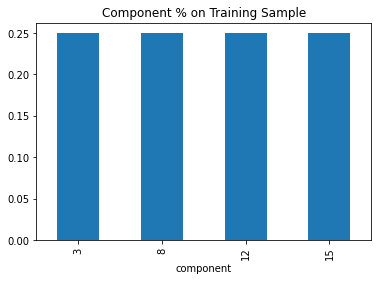

Generating Fasta and Motis: train
------------------------------
Generating Motifs (all seqs)
Computing Motifs....
2022-11-26 10:17:40,749 - INFO - No config found.
2022-11-26 10:17:40,750 - INFO - Creating new config.
2022-11-26 10:17:40,752 - INFO - Using included version of MDmodule.
2022-11-26 10:17:40,777 - WARNING - MEME not found. To include it you will have to install it.
2022-11-26 10:17:40,797 - WARNING - MEMEW not found. To include it you will have to install it.
2022-11-26 10:17:40,854 - WARNING - DREME not found. To include it you will have to install it.
2022-11-26 10:17:40,911 - WARNING - Weeder not found. To include it you will have to install it.
2022-11-26 10:17:40,950 - WARNING - GADEM not found. To include it you will have to install it.
2022-11-26 10:17:40,950 - INFO - Using included version of MotifSampler.
2022-11-26 10:17:40,978 - WARNING - Trawler not found. To include it you will have to install it.
2022-11-26 10:17:40,978 - INFO - Using included version of Im

In [15]:
# Note that this .csv dataset should be downloaded from here: !wget https://www.dropbox.com/s/db6up7c0d4jwdp4/train_all_classifier_WM20220916.csv.gz?dl=2
# And then potentially saved locally (in gc drive)
raw_data = DataLoading(
    "train_all_classifier_WM20220916.csv", subset_components=[3, 8, 12, 15]
)
preprocessed_data = DataPreprocessing(
    raw_data.df_train_raw_grouped,
    raw_data.df_test_raw_grouped,
    raw_data.df_shuffled_raw_grouped,
    subset_components=[3, 8, 12, 15],
    sample_number=raw_data.sample_number,
)

# Stable Diffusion architecture

Main things to note for this part of the code:

There are 3 core elements of stable diffusion.


1.   Variational autoencoder
2.   UNET 
3.   (optionally) Text encoder in order to translate initially text to a latent space describing the image.


The VAE encoder compresses the image from pixel space to a smaller dimensional latent space, capturing a more fundamental semantic meaning of the image.
Gaussian noise is iteratively applied to the compressed latent representation during forward diffusion.
The U-Net block, composed of a ResNet backbone, denoises the output from forward diffusion backwards to obtain latent representation. 
Finally, the VAE decoder generates the final image by converting the representation back into pixel space.
The denoising step can be flexibly conditioned on a string of text, an image, and other modalities.

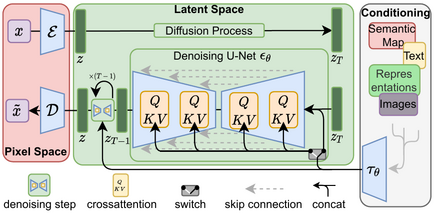

**DO NOTE:** that in this particular work currently we have seperate the VA and the UNET. Meaning the Bit Diffusion with solely UNET is depicted here whereas VA which finds suitable latent space is currently developed seperately.

# Stable Diffusion architecture

This chapter is divided into following sub-chapters:


1.   Sampling functions
2.   Utility functions for UNET
3.   Bit diffusion UNET

The main components of UNET have been taken from this implementation here: https://github.com/lucidrains/bit-diffusion

The main differences are:


*   No Self-Conditioning
*   Diffusion conditioned on components.
*   Substantially different forward pass
*   Conditioned Attention block
*   Classifier-Free Diffusion Guidance





# Classifier-Free Diffusion Guidance

Its idea stemming from https://openreview.net/pdf?id=qw8AKxfYbI

But first of all what is **guidance** (for **conditional** diffusion models)?

TL;DR Following the Bayes Rule we can express conditional distribution as such.

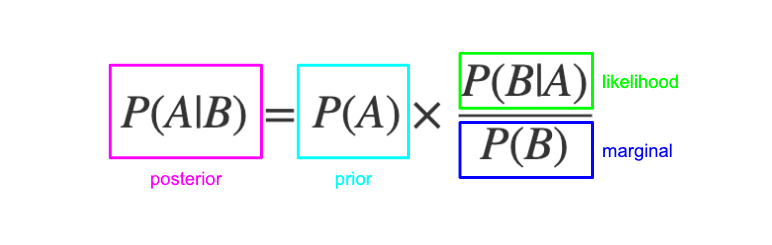

Now to estimate the marginal term we  we can use classifiers (which have their problems) OR we can proceed classifier free, where we will increase our samply efficiency (since we have conditioned on additional information) and we can do it efficiently. Read more [here](https://benanne.github.io/2022/05/26/guidance.html).

Classifier-Free Diffusion Guidance was developed to achieve trade off between sample quality and diversity similar to that obtained using classifier guidance. This approach happens post training of conditional diffusion models. (See training loop below and sample function)

Simple idea behind it is: "*We show that guidance (of the generative model) can be performed by a pure generative
model without such a classifier: we jointly train a conditional and an unconditional
diffusion model, and find that it is possible to combine the resulting conditional
and unconditional scores to attain the afromentioned  trade-off between sample quality and diversity
similar to that obtained using classifier guidance.*"


And this is exactly what the following block of code is for, we will sample efficiently from guided/conditioned stable diffusion:

In [16]:
# Scheduler


def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = (
        torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    )
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)


def linear_beta_schedule(timesteps, beta_end=0.005):
    beta_start = 0.0001

    return torch.linspace(beta_start, beta_end, timesteps)


def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2


def sigmoid_beta_schedule(timesteps):
    beta_start = 0.001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start


# define beta schedule
betas = linear_beta_schedule(timesteps=TIMESTEPS, beta_end=0.2)
# define alphas
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
# sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = (
    betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
)


def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


# Conditioned (improved) sampling


@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    # print (x.shape, 'x_shape')
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, time=t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise


# Sampling based on Denoising Diffusion Implicit Models (https://arxiv.org/abs/2010.02502)


@torch.no_grad()
def p_ddim_sample(model, x, t, t_index, eta=0, temp=1.0):
    alpha_t = extract(alphas_cumprod, t, x.shape)
    alpha_prev_t = extract(alphas_cumprod_prev, t, x.shape)
    sigma = (
        eta
        * ((1 - alpha_prev_t) / (1 - alpha_t) * (1 - alpha_t / alpha_prev_t))
        ** 0.5
    )
    sqrt_one_minus_alphas_cumprod = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    pred_x0 = (x - sqrt_one_minus_alphas_cumprod * model(x, time=t)) / (
        alpha_t**0.5
    )
    dir_xt = (1.0 - alpha_prev_t - sigma**2).sqrt() * model(x, time=t)
    if sigma == 0.0:
        noise = 0.0
    else:
        noise = torch.randn((1, x.shape[1:]))
    noise *= temp

    x_prev = (alpha_prev_t**0.5) * pred_x0 + dir_xt + sigma * noise

    return x_prev


@torch.no_grad()
def p_sample_guided(
    model, x, classes, t, t_index, context_mask, cond_weight=0.0
):
    # adapted from: https://openreview.net/pdf?id=qw8AKxfYbI
    # print (classes[0])
    batch_size = x.shape[0]
    # double to do guidance with
    t_double = t.repeat(2)
    x_double = x.repeat(2, 1, 1, 1)
    betas_t = extract(betas, t_double, x_double.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t_double, x_double.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t_double, x_double.shape)

    # classifier free sampling interpolates between guided and non guided using `cond_weight`
    classes_masked = classes * context_mask
    classes_masked = classes_masked.type(torch.long)
    # print ('class masked', classes_masked)
    preds = model(x_double, time=t_double, classes=classes_masked)
    eps1 = (1 + cond_weight) * preds[:batch_size]
    eps2 = cond_weight * preds[batch_size:]
    x_t = eps1 - eps2

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t[:batch_size] * (
        x
        - betas_t[:batch_size]
        * x_t
        / sqrt_one_minus_alphas_cumprod_t[:batch_size]
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise


# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, classes, shape, cond_weight):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    if classes is not None:
        n_sample = classes.shape[0]
        context_mask = torch.ones_like(classes).to(device)
        # make 0 index unconditional
        # double the batch
        classes = classes.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 0.0  # makes second half of batch context free
        sampling_fn = partial(
            p_sample_guided,
            classes=classes,
            cond_weight=cond_weight,
            context_mask=context_mask,
        )
    else:
        sampling_fn = partial(p_sample)

    for i in tqdm(
        reversed(range(0, TIMESTEPS)),
        desc='sampling loop time step',
        total=TIMESTEPS,
    ):
        img = sampling_fn(
            model,
            x=img,
            t=torch.full((b,), i, device=device, dtype=torch.long),
            t_index=i,
        )
        imgs.append(img.cpu().numpy())
    return imgs


@torch.no_grad()
def sample(
    model, image_size, classes=None, batch_size=16, channels=3, cond_weight=0
):
    return p_sample_loop(
        model,
        classes=classes,
        shape=(batch_size, channels, 4, image_size),
        cond_weight=cond_weight,
    )

### Loss function

In [17]:
def q_sample(x_start, t, noise=None):
    """
    Forward pass with noise.
    """
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return (
        sqrt_alphas_cumprod_t * x_start
        + sqrt_one_minus_alphas_cumprod_t * noise
    )


def p_losses(
    denoise_model, x_start, t, classes, noise=None, loss_type="l1", p_uncond=0.1
):
    """
    Calculate the loss conditioned and noise injected.
    """
    device = x_start.device
    if noise is None:
        noise = torch.randn_like(x_start)  #  gauss noise
    x_noisy = q_sample(
        x_start=x_start, t=t, noise=noise
    )  # this is the auto generated noise given t and Noise

    context_mask = torch.bernoulli(
        torch.zeros(classes.shape[0]) + (1 - p_uncond)
    ).to(device)

    # mask for unconditinal guidance
    classes = classes * context_mask
    classes = classes.type(torch.long)
    predicted_noise = denoise_model(x_noisy, t, classes)
    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

# Stable Diffusion architecture

This part of the code has been adapted from https://github.com/lucidrains/bit-diffusion/blob/main/bit_diffusion/bit_diffusion.py and for the paper
[*Analog Bits: Generating Discrete Data
using Diffusion Models with Self-Conditioning*](https://arxiv.org/pdf/2208.04202.pdf)

The core changes are indicated with comment 

"*# Additional code to the https://github.com/lucidrains/bit-diffusion/blob/main/bit_diffusion/bit_diffusion.py*"

In [18]:
def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d


def cycle(dl):
    while True:
        for data in dl:
            yield data


def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num


def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr


def convert_image_to(img_type, image):
    if image.mode != img_type:
        return image.convert(img_type)
    return image


def l2norm(t):
    return F.normalize(t, dim=-1)


def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d


# Building blocks of UNET


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding=1),
    )


def Downsample(dim, dim_out=None):
    return nn.Conv2d(dim, default(dim_out, dim), 4, 2, 1)


class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim=1, unbiased=False, keepdim=True)
        mean = torch.mean(x, dim=1, keepdim=True)
        return (x - mean) * (var + eps).rsqrt() * self.g


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)


# Building blocks of UNET, positional embeds


class LearnedSinusoidalPosEmb(nn.Module):
    """following @crowsonkb 's lead with learned sinusoidal pos emb"""

    """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """

    def __init__(self, dim):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim))

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim=-1)
        fouriered = torch.cat((x, fouriered), dim=-1)
        return fouriered


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


# Building blocks of UNET, building block modules


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


# Building blocks of UNET, residual part


class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = (
            nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()
        )

    def forward(self, x, time_emb=None):
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)


# Additional code to the https://github.com/lucidrains/bit-diffusion/blob/main/bit_diffusion/bit_diffusion.py


class ResnetBlockClassConditioned(ResnetBlock):
    def __init__(
        self,
        dim,
        dim_out,
        *,
        num_classes,
        class_embed_dim,
        time_emb_dim=None,
        groups=8,
    ):
        super().__init__(
            dim=dim + class_embed_dim,
            dim_out=dim_out,
            time_emb_dim=time_emb_dim,
            groups=groups,
        )
        self.class_mlp = EmbedFC(num_classes, class_embed_dim)

    def forward(self, x, time_emb=None, c=None):
        emb_c = self.class_mlp(c)
        emb_c = emb_c.view(*emb_c.shape, 1, 1)
        emb_c = emb_c.expand(-1, -1, x.shape[-2], x.shape[-1])
        x = torch.cat([x, emb_c], axis=1)

        return super().forward(x, time_emb)


# Building blocks of UNET, attention part


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1), LayerNorm(dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h=self.heads),
            qkv,
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        v = v / (h * w)

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(
            out, 'b h c (x y) -> b (h c) x y', h=self.heads, x=h, y=w
        )
        return self.to_out(out)


class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32, scale=10):
        super().__init__()
        self.scale = scale
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h=self.heads),
            qkv,
        )

        q, k = map(l2norm, (q, k))

        sim = einsum('b h d i, b h d j -> b h i j', q, k) * self.scale
        attn = sim.softmax(dim=-1)
        out = einsum('b h i j, b h d j -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x=h, y=w)
        return self.to_out(out)


# Core part of UNET


class Unet(nn.Module):
    """
    Refer to the main paper for the architecture details https://arxiv.org/pdf/2208.04202.pdf
    """

    def __init__(
        self,
        dim,
        init_dim=IMAGE_SIZE,
        dim_mults=(1, 2, 4),
        channels=CHANNELS,
        resnet_block_groups=8,
        learned_sinusoidal_dim=18,
        num_classes=10,
        class_embed_dim=3,
    ):
        super().__init__()

        self.channels = channels
        # if you want to do self conditioning uncomment this
        # input_channels = channels * 2
        input_channels = channels

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, (7, 7), padding=3)
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        time_dim = dim * 4

        sinu_pos_emb = LearnedSinusoidalPosEmb(learned_sinusoidal_dim)
        fourier_dim = learned_sinusoidal_dim + 1

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Downsample(dim_in, dim_out)
                        if not is_last
                        else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(
                            dim_out + dim_in, dim_out, time_emb_dim=time_dim
                        ),
                        block_klass(
                            dim_out + dim_in, dim_out, time_emb_dim=time_dim
                        ),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in)
                        if not is_last
                        else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, 1, 1)
        print('final', dim, channels, self.final_conv)

    # Additional code to the https://github.com/lucidrains/bit-diffusion/blob/main/bit_diffusion/bit_diffusion.py mostly in forward method.

    def forward(self, x, time, classes, x_self_cond=None):
        x = self.init_conv(x)
        r = x.clone()

        t_start = self.time_mlp(time)
        t_mid = t_start.clone()
        t_end = t_start.clone()

        if classes is not None:
            t_start += self.label_emb(classes)
            t_mid += self.label_emb(classes)
            t_end += self.label_emb(classes)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t_start)
            h.append(x)

            x = block2(x, t_start)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t_mid)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t_mid)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t_mid)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t_mid)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)
        x = self.final_res_block(x, t_end)

        x = self.final_conv(x)
        return x

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [23]:
model = Unet(
    dim=IMAGE_SIZE,
    channels=CHANNELS,
    dim_mults=(1, 2, 4),
    resnet_block_groups=RESNET_BLOCK_GROUPS,
    num_classes=TOTAL_CLASS_NUMBER,
).cuda()

model.to(device)

optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

live_kl = PlotLosses(
    groups={'KL': ['train', 'test', 'shuffle'], 'DiffusionLoss': ['loss']}
)
train_kl, test_kl, shuffle_kl = 1, 1, 1

final 200 1 Conv2d(200, 1, kernel_size=(1, 1), stride=(1, 1))


# Stable Diffusion training metric functions and evaluation

We need a Pytorch like interface:

In [24]:
class SequenceDataset(Dataset):
    'Characterizes a dataset for PyTorch'

    def __init__(self, seqs, c, transform=None):
        'Initialization'
        self.seqs = seqs
        self.c = c
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.seqs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        image = self.seqs[index]

        x = self.transform(image)

        y = self.c[index]

        return x, y

We extract the morids and counts of motifs per component from the preprocessed data object:

In [25]:
df_results_seq_guime_count_train = preprocessed_data.train['motifs']
df_results_seq_guime_count_test = preprocessed_data.test['motifs']
df_results_seq_guime_count_shuffle = preprocessed_data.train_shuffle['motifs']


final_comp_values_train = preprocessed_data.train['motifs_per_components_dict']
final_comp_values_test = preprocessed_data.test['motifs_per_components_dict']
final_comp_values_shuffle = preprocessed_data.train_shuffle[
    'motifs_per_components_dict'
]

raw_dataset = preprocessed_data.train['dataset']
cell_components = (
    raw_dataset.sort_values('component')['component'].unique().tolist()
)

We take the raw sequence and we group it by components before feeding it into the model:

In [26]:
X_train = np.array(
    [
        one_hot_encode(x, NUCLEOTIDES, 200)
        for x in tqdm_notebook(raw_dataset['raw_sequence'])
        if 'N' not in x
    ]
)
X_train = np.array([x.T.tolist() for x in X_train])
X_train[X_train == 0] = -1
# conditional training init
cell_types = sorted(list(raw_dataset.component.unique()))
x_train_cell_type = torch.from_numpy(raw_dataset["component"].to_numpy())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/1000 [00:00<?, ?it/s]

Then we initialize the torch compatible interface:

In [27]:
tf = T.Compose([T.ToTensor()])
seq_dataset = SequenceDataset(seqs=X_train, c=x_train_cell_type, transform=tf)
train_dl = DataLoader(
    seq_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)

Next we define a function that will sample from our trained stable diffusion the DNS samples and we are going to use the occurances of the sampled examples to evaluate our metric across train,test and shuffled examples

In [28]:
def sampling_to_metric(
    number_of_samples=20,
    specific_group=False,
    group_number=None,
    cond_weight_to_metric=0,
):
    """
    This function encapsulates the logic of sampling from the trained model in order to generate counts of the motifs.
    The reasoning is that we are interested only in calculating the evaluation metric
    for the count of occurances and not the nucleic acids themselves.
    """
    final_sequences = []
    for n_a in tqdm_notebook(range(number_of_samples)):
        sample_bs = 10
        if specific_group:
            sampled = torch.from_numpy(np.array([group_number] * sample_bs))
            print('specific')
        else:
            sampled = torch.from_numpy(np.random.choice(cell_types, sample_bs))

        random_classes = sampled.float().cuda()
        sampled_images = sample(
            model,
            classes=random_classes,
            image_size=IMAGE_SIZE,
            batch_size=sample_bs,
            channels=1,
            cond_weight=cond_weight_to_metric,
        )
        for n_b, x in enumerate(sampled_images[-1]):
            seq_final = f'>seq_test_{n_a}_{n_b}\n' + ''.join(
                [NUCLEOTIDES[s] for s in np.argmax(x.reshape(4, 200), axis=0)]
            )
            final_sequences.append(seq_final)

    save_motifs_syn = open('synthetic_motifs.fasta', 'w')

    save_motifs_syn.write('\n'.join(final_sequences))
    save_motifs_syn.close()
    # Scan for motifs
    !gimme scan synthetic_motifs.fasta -p   JASPAR2020_vertebrates -g hg38 > syn_results_motifs.bed
    df_results_syn = pd.read_csv(
        'syn_results_motifs.bed', sep='\t', skiprows=5, header=None
    )
    df_results_syn['motifs'] = df_results_syn[8].apply(
        lambda x: x.split('motif_name "')[1].split('"')[0]
    )
    df_results_syn[0] = df_results_syn[0].apply(
        lambda x: '_'.join(x.split('_')[:-1])
    )
    df_motifs_count_syn = (
        df_results_syn[[0, 'motifs']]
        .drop_duplicates()
        .groupby('motifs')
        .count()
    )
    plt.rcParams["figure.figsize"] = (30, 2)
    df_motifs_count_syn.sort_values(0, ascending=False).head(50)[0].plot.bar()
    plt.show()

    return df_motifs_count_syn

In [29]:
gc.collect()
torch.cuda.empty_cache()

Here we train the model, and after certain epochs we compare the loss and the wether the metric of choices actually decreases across the train test and shuffle datasets.

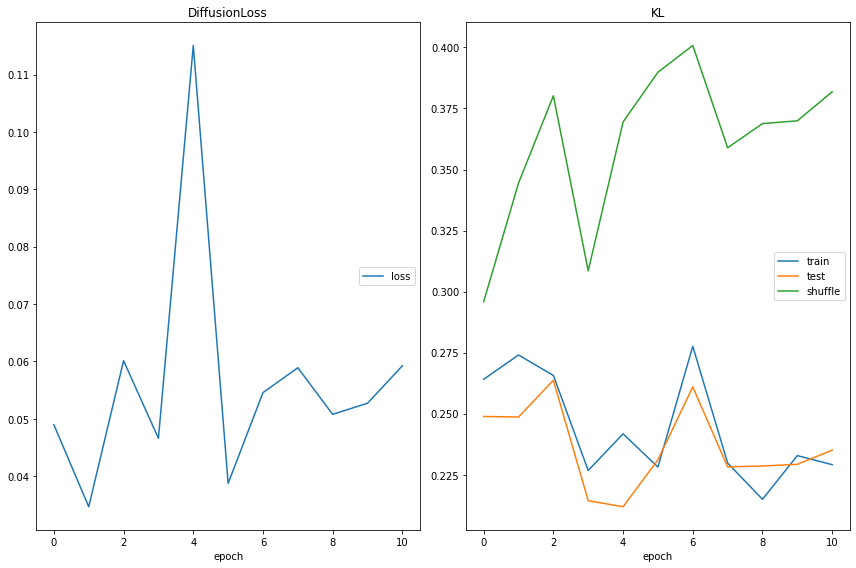

DiffusionLoss
	loss             	 (min:    0.035, max:    0.115, cur:    0.059)
KL
	train            	 (min:    0.215, max:    0.278, cur:    0.229)
	test             	 (min:    0.212, max:    0.264, cur:    0.235)
	shuffle          	 (min:    0.296, max:    0.401, cur:    0.382)
 Epoch 60 Loss: 0.03460527956485748
saving


sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

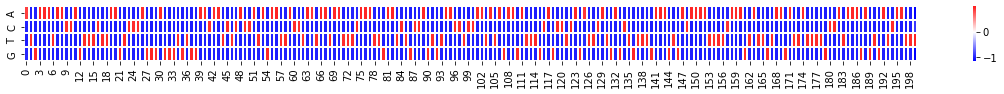

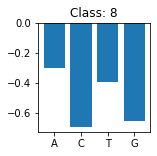

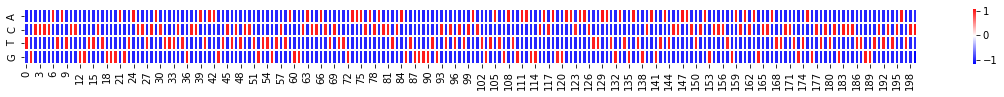

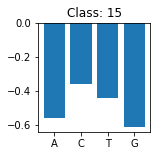

  0%|          | 0/20 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [30]:
ema = EMA(0.995)
ema_model = copy.deepcopy(model).eval().requires_grad_(False)


for epoch in tqdm(range(EPOCHS)):
    model.train()
    for step, batch in enumerate(train_dl):
        x, y = batch
        x = x.type(torch.float32).to(device)
        y = y.type(torch.long).to(device)
        batch_size = x.shape[0]

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(
            0, TIMESTEPS, (batch_size,), device=device
        ).long()  # sampling a t to generate t and t+1
        loss = p_losses(model, x, t, y, loss_type="huber")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ema.step_ema(ema_model, model)

    if (epoch % EPOCHS_LOSS_SHOW) == 0:
        print(f" Epoch {epoch} Loss:", loss.item())

    # save generated images
    if epoch != 0 and epoch % SAVE_AND_SAMPLE_EVERY == 0:
        model.eval()
        print('saving')
        milestone = step // SAVE_AND_SAMPLE_EVERY
        sample_bs = 2
        # This needs to be fixed to the random
        sampled = torch.from_numpy(np.random.choice(cell_types, sample_bs))
        random_classes = sampled.cuda()

        samples = sample(
            model,
            classes=random_classes,
            image_size=IMAGE_SIZE,
            batch_size=2,
            channels=1,
            cond_weight=1,
        )
        n_print = 0
        for image, class_show in zip(samples[-1], random_classes):
            if n_print < 4:
                plt.rcParams["figure.figsize"] = (20, 1)
                pd_seq = pd.DataFrame(image.reshape(4, 200))
                pd_seq.index = NUCLEOTIDES
                sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0)
                plt.show()
                plt.rcParams["figure.figsize"] = (2, 2)

                plt.bar(NUCLEOTIDES, pd_seq.mean(1).T)
                plt.title(f'Class: {class_show}')
                plt.show()
                n_print = n_print + 1

        synt_df = sampling_to_metric(20)
        train_kl = compare_motif_list(synt_df, df_results_seq_guime_count_train)
        test_kl = compare_motif_list(synt_df, df_results_seq_guime_count_test)
        shuffle_kl = compare_motif_list(
            synt_df, df_results_seq_guime_count_shuffle
        )
        print('KL_TRAIN', train_kl, 'KL')
        print('KL_TEST', test_kl, 'KL')
        print('KL_SHUFFLE', shuffle_kl, 'KL')
        print('train', train_kl)
        print('test_kl', test_kl)
        print('shuffle_kl', shuffle_kl)
        print('loss', loss.item())
        live_kl.update(
            {
                'train': train_kl,
                'test': test_kl,
                'shuffle': shuffle_kl,
                'loss': loss.item(),
            }
        )
        # DO NOTE ONE THING: THE X AXIS IS NOT THE EPOCHS, but epochs*save_and_sample_every
        live_kl.send()

Finally lets compare a heatmap of the (KL) metric between the different components:

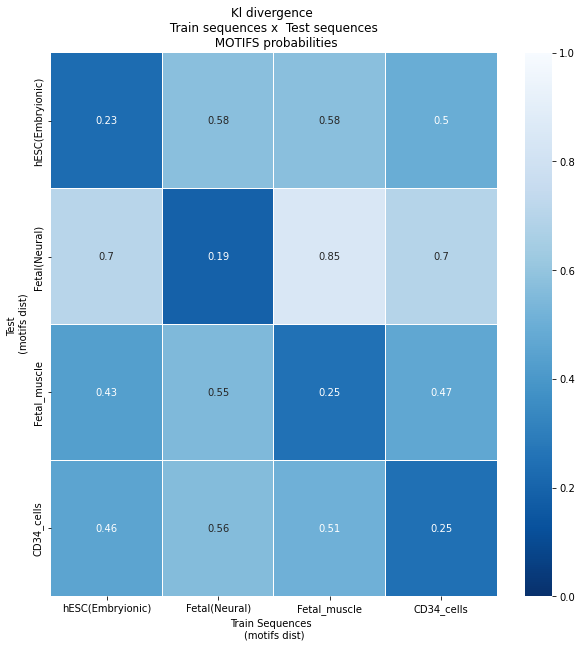

In [31]:
metric_comparison_between_components(
    final_comp_values_train, final_comp_values_test, "Train", "Test"
)

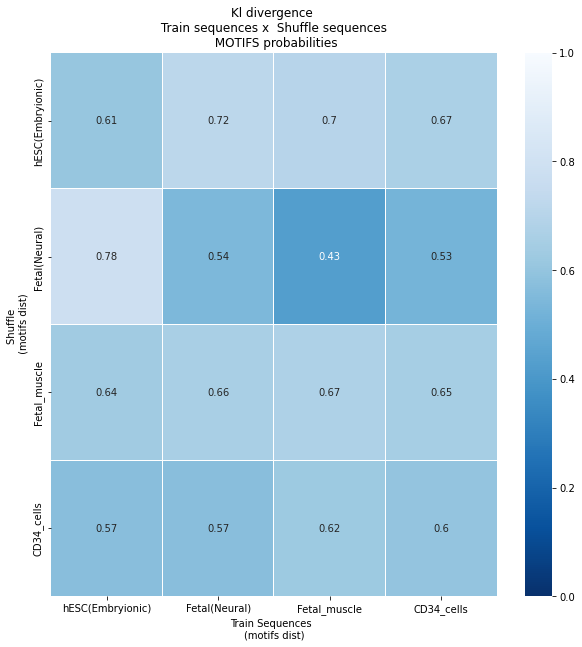

In [32]:
metric_comparison_between_components(
    final_comp_values_train, final_comp_values_shuffle, "Train", "Shuffle"
)

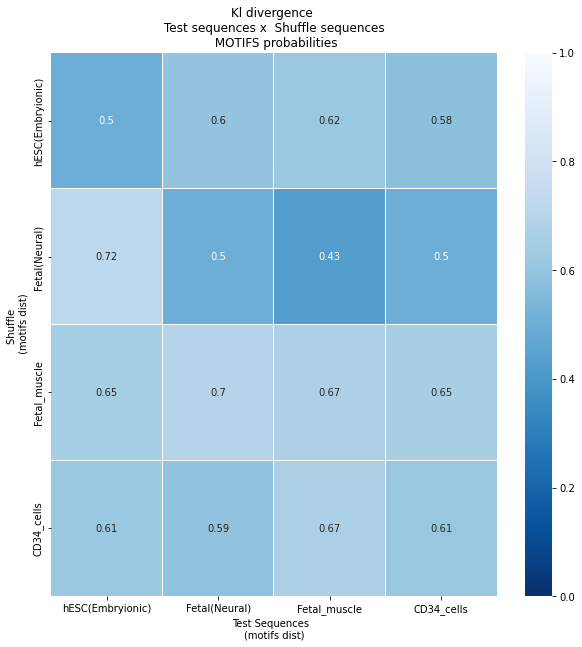

In [33]:
metric_comparison_between_components(
    final_comp_values_test, final_comp_values_shuffle, "Test", "Shuffle"
)